In [13]:
#import necessary libraries for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#for auth
import os
from dotenv import load_dotenv

#for spotify api
import spotipy
from spotipy.oauth2 import SpotifyOAuth

In [22]:
#get credentials from .env
load_dotenv()

#set up spotipy
client_id=os.getenv('SPOTIPY_CLIENT_ID')
client_secret=os.getenv('SPOTIPY_CLIENT_SECRET')
redirect_uri=os.getenv('SPOTIPY_REDIRECT_URI')

scope='user-top-read'

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
                                               client_secret=client_secret,
                                               redirect_uri=redirect_uri,
                                                scope=scope))

<Axes: title={'center': 'Percent of My Top 50 Tracks that an Artist Takes Up'}>

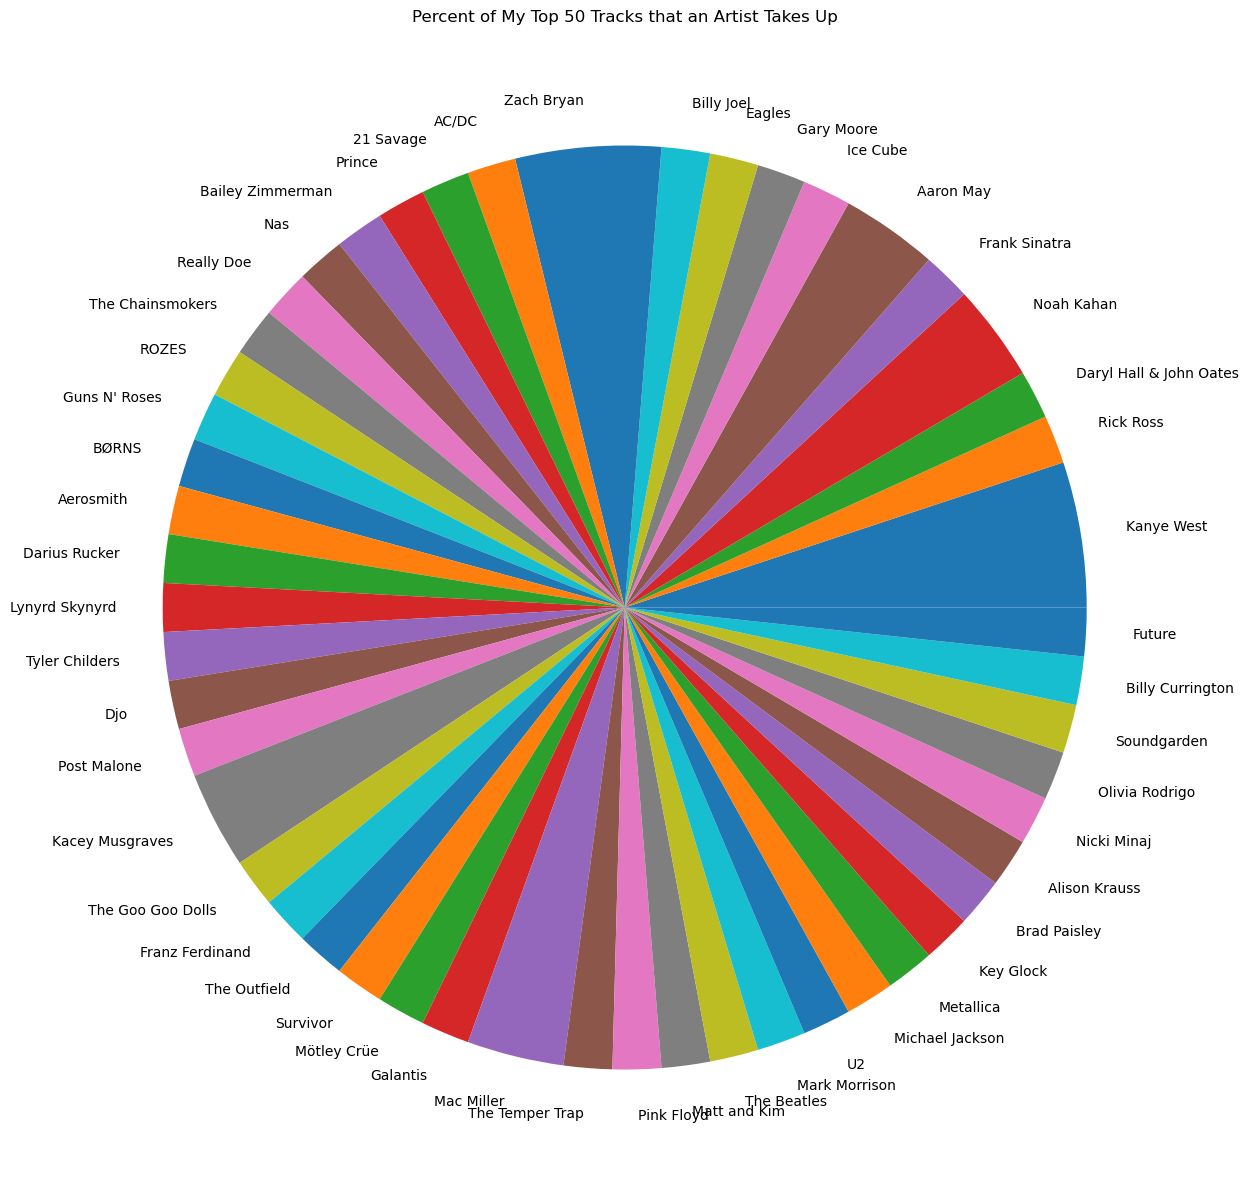

In [77]:
#first question that popped into my head (what percentage of my top songs are taken up by one artist? How much of a fanboy am I?)
top_tracks_last_year = pd.DataFrame(sp.current_user_top_tracks(limit=50, time_range='long_term')['items'])

#create a series of the 'artists' field  from the top tracks dataframe
all_artists = top_tracks_last_year['artists']

#create a dictionary to store and keep track of # of artist appearances
artist_dict = {}

#count how many times an artist appears in my top 50 tracks over the last year
for song_artists in all_artists:
    for artist in song_artists:
        if artist['name'] not in artist_dict.keys():
            artist_dict[artist['name']] = 1
        else:
            artist_dict[artist['name']] += 1
    
#transform dict to series to plot it
artist_df = pd.DataFrame(artist_dict.items(), columns=['name', 'count']).set_index(['name'])

#add percentage column
artist_df['percentage'] = round(artist_df / artist_df.sum() * 100, 1)

#plot pie chart of percentages
artist_df['percentage'].plot(kind='pie', figsize=(15,15), ylabel='', title='Percent of My Top 50 Tracks that an Artist Takes Up',
                             fontsize=7)
    